In [1]:
import os
import math
import random
import operator
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import math

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from operator import itemgetter

In [12]:
def load_file(data_file_path):
    data_df = pd.read_csv(data_file_path, delimiter=";")
    return data_df


def compute_reward_individual(num_calls, result, cost_per_call = 1):
    if result == "yes":
        return (11 - (cost_per_call * num_calls))
    elif result == "no":
        return (-1 * (cost_per_call * num_calls))
    

def compute_y_position_label(y_val):
    if y_val >= 0.0:
        return 'bottom'
    else:
        return 'top'
    

def div(a,b):
    if int(b) == 0:
        return 0.0
    else:
        return a/b
        

def plot_graph(x, y, key, bar_plot, digregard_x_axis):
    style = dict(size=8, color='red')
    new_x = []
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            new_x.append(i)
    else:
        new_x = x
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    if bar_plot:
        ax.bar(new_x, y, 0.75)
    else:
        # plt.xlim((x[0],x[-1]))
        ax.plot(x, y)
    if digregard_x_axis:
        for i in range(1, len(x)+1):
            ax.text(i, y[i-1], x[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
        ax.axes.get_xaxis().set_visible(False)
    else:
        for i in range(1, len(x)+1):
            ax.text(x[i-1], y[i-1], y[i-1], ha='center', verticalalignment=compute_y_position_label(y[i-1]), **style)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel=str(key), ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    plt.show()
    

def plot_graph_balance(x, y, key, step):
    style = dict(size=8, color='black')
    fig, ax = plt.subplots(figsize = (14, 6))
    # plt.xticks(np.arange(len(x)), x, rotation=75)
    # ax.tick_params(axis='x', which='major', pad=20)
    ax.bar(x, y, 0.75)
    # Setting title and labels.
    title = "Expected reward vs " +  str(key)
    ax.set(xlabel= "Average yearly balance", ylabel='Expected Reward', title=title)
    # plt.axvline(x=0, color ="black")
    plt.axhline(y=0, color ="black")
    # ax.grid()
    plt.tight_layout()
    tick_labels = ['-ve', '-ve', '-ve']
    for i in range (1, len(x)+1):
        tick_labels.append(str((i-1)*step) +'-' + str(i * step))
    ax.set_xticklabels(tick_labels ,rotation='vertical')
    plt.show()


def analyze_results(reward_values_list_sorted):
    num_pos = 0
    num_neg = 0
    num_pos_avg = 0.0
    num_neg_avg = 0.0
    for item in reward_values_list_sorted:
        ref = item[1]
        if ref['expected'] >= 0.0:
            num_pos += 1
            num_pos_avg += ref['expected']
        else:
            num_neg += 1
            num_neg_avg += ref['expected']
    print("# Positive: ", num_pos)
    print("# Negative:", num_neg)
    print("Pos - Avg. Expected:", div(num_pos_avg,num_pos))
    print("Neg - Avg. Expected:", div(num_neg_avg,num_neg))

In [18]:
def compute_plot_value_rows_by_key(mkt_df, key, bar_plot, digregard_x_axis):
    values = mkt_df[key].unique()
    reward_values ={}
    total_count = 0
    total_value = 0.0
    for value_ref in values:
        reward_values[value_ref] = {'value':0.0, 'y_count':0, 'n_count':0, 'expected':None}
    for index, row in mkt_df.iterrows():
        value_ref = row[key]
        reward_values[value_ref]['value'] += (compute_reward_individual(row['campaign'], row['y']))
        if row['y'] == "yes":
            reward_values[value_ref]['y_count'] += 1
        elif row['y'] == "no":
            reward_values[value_ref]['n_count'] += 1
        total_count += 1
    for item in reward_values:
        ref = reward_values[item]
        total_value += ref['value']
        ref['expected'] = div(ref['value'], (ref['y_count'] + ref['n_count']))
    reward_values_list = reward_values.items()
    reward_values_list_sorted = sorted(reward_values_list, key=lambda tup: tup[1]['expected'], reverse=True)
    print("Total Value is:", total_value)
    x = []
    y = []
#     print("List of x,y pairs: ")
    i = 1
    for item in reward_values_list_sorted:
        print(item, end='\n')
        if i%6 == 0:
            print("\n")
        x.append(item[0])
        y.append((item[1]['expected']))
        i += 1
#     analyze_results(reward_values_list_sorted)
#     print("Y is:")
#     print(y)
    plot_graph(x, y, key, bar_plot, digregard_x_axis)

    
def compute_plot_balance_value(mkt_df, step = 2500):
    min = mkt_df['balance'].values.min()
    max = mkt_df['balance'].values.max()
    reward_value = {}
    total_count = 0
    for i in range(min, max, step):
        reward_value[(int(i/step))] = {'value':0.05, 'count':0}
#         print("Max is:", max)
    for index, row in mkt_df.iterrows():
        bal = row['balance']
        bal_index = None
        if bal <0.0:
            bal_index = -1
        else:
            bal_index = int(bal/step)
        reward_value[bal_index]['value'] += compute_reward_individual(row['campaign'], row['y'])
        reward_value[bal_index]['count'] += 1
        total_count += 1
    x = [str(key) for key in reward_value.keys()]
    y = [div(item['value'],item['count']) for item in reward_value.values()]
#     print(reward_value)
    plot_graph_balance(x, y, 'balance', step)

In [9]:
# This function takes the data corresponding to a feature set and computes the expected values for calls
# ranging from 1 .. 10.
def compute_expected_reward_feature_set(fs_df, no_calls):
    expected_values_calls = []
    for i in range(0, no_calls):
        expected_values_calls.append({'value':0.0, 'count':0, 'expected':0.0})
    for index, row in fs_df.iterrows():
        expected_values_calls[row['campaign']-1]['value'] += compute_reward_individual(row['campaign'], row['y'])
        expected_values_calls[row['campaign']-1]['count'] += 1
    for i in range(0, no_calls):
        expected_values_calls[i]['expected'] = div(expected_values_calls[i]['value'], expected_values_calls[i]['count'])
    return expected_values_calls

In [10]:
# Given a dictionary of what attributes comprise a feature set, we can get all rows corresponding to this feature set.
def extract_rows_feature_set(fs_df, feature_labels = {'education':['tertiary', 'secondary'], 'job':['technician']}):
    for key in feature_labels:
        feature_labels_query_str = ''
        arr = feature_labels[key]
        for label in arr:
            feature_labels_query_str += (key + ' == "'+ label + '" | ')
        feature_labels_query_str = feature_labels_query_str[:-3]
        fs_df = fs_df.query(feature_labels_query_str)
    return fs_df

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


Total Value is: -47177.0
(90, {'value': 18.0, 'y_count': 2, 'n_count': 0, 'expected': 9.0})
(93, {'value': 18.0, 'y_count': 2, 'n_count': 0, 'expected': 9.0})
(92, {'value': 15.0, 'y_count': 2, 'n_count': 0, 'expected': 7.5})
(87, {'value': 28.0, 'y_count': 3, 'n_count': 1, 'expected': 7.0})
(85, {'value': 34.0, 'y_count': 4, 'n_count': 1, 'expected': 6.8})
(68, {'value': 177.0, 'y_count': 21, 'n_count': 15, 'expected': 4.916666666666667})


(18, {'value': 56.0, 'y_count': 7, 'n_count': 5, 'expected': 4.666666666666667})
(84, {'value': 36.0, 'y_count': 5, 'n_count': 4, 'expected': 4.0})
(73, {'value': 175.0, 'y_count': 24, 'n_count': 20, 'expected': 3.977272727272727})
(86, {'value': 30.0, 'y_count': 4, 'n_count': 4, 'expected': 3.75})
(62, {'value': 284.0, 'y_count': 39, 'n_

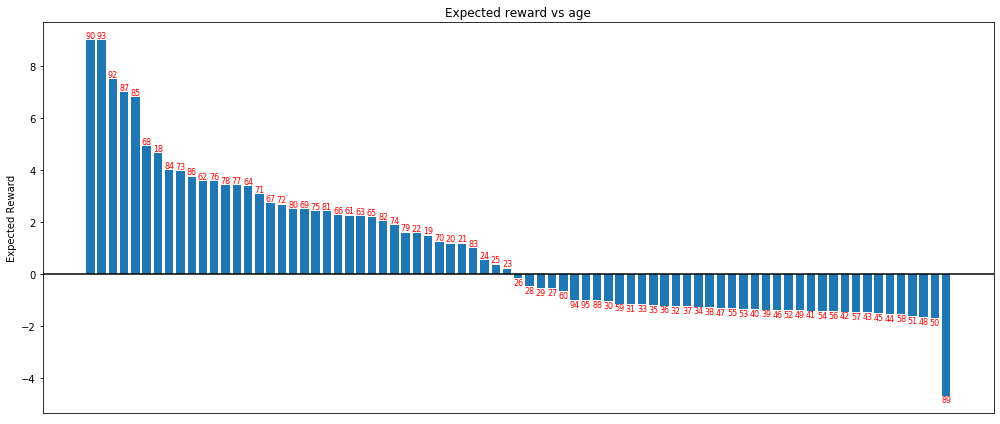

In [20]:
current_dir = os.getcwd()
mkt_df = load_file(current_dir + '/bank-full.csv')
mkt_df_filtered = mkt_df[(mkt_df['campaign']>=1) & (mkt_df['campaign']<=10)] # & (mkt_df['education']!="unknown")
# df1 = mkt_df_filtered.head(300)
print(mkt_df_filtered.columns)
print("\n")
# This is working.
# result = extract_rows_feature_set(mkt_df_filtered)
compute_plot_value_rows_by_key(mkt_df_filtered, 'age', True, True)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'education', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'marital', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'job', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'default', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'housing', True, False)
# compute_plot_value_rows_by_key(mkt_df_filtered, 'loan', True, False)
# compute_plot_balance_value(mkt_df_filtered)

In [ ]:
# print(len(mkt_df_filtered[(mkt_df_filtered['education'] == 'secondary') & (mkt_df_filtered['y'] == 'yes')]))
# print(len(mkt_df_filtered[(mkt_df_filtered['education'] == 'secondary') & (mkt_df_filtered['y'] == 'no')]))
# total_v = 0.0
# for index, row in mkt_df_filtered.iterrows():
#     if row['education'] == 'secondary':
#         if row['y'] == "yes":
#             total_v += (11 - row['campaign'])
#         else:
#             total_v -= (row['campaign'])
# print(total_v)
# print()

In [ ]:
#Important information about dataset.
print(len(mkt_df_filtered[mkt_df_filtered['y']=="yes"]))
print(len(mkt_df_filtered[mkt_df_filtered['y']=="no"]))

In [ ]:
my_str =  'education == "tertiary"'
mkt_df_filtered.query(my_str)

In [ ]:
mkt_df_filtered.query('age == 93')

In [ ]:
mkt_df_filtered.query('age == 87')